# Covid-19 Vaccine Sentiment Analysis

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud,STOPWORDS
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import random
plt.rc('figure',figsize=(17,13))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/aryagowda/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
f_data = pd.read_csv('vaccination_tweets.csv')
f_data.text =f_data.text.str.lower()

#Remove twitter handlers
f_data.text = f_data.text.apply(lambda x:re.sub('@[^\s]+','',x))

#remove hashtags
f_data.text = f_data.text.apply(lambda x:re.sub(r'\B#\S+','',x))


# Remove URLS
f_data.text = f_data.text.apply(lambda x:re.sub(r"http\S+", "", x))

# Remove all the special characters
f_data.text = f_data.text.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#remove all single characters
f_data.text = f_data.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substituting multiple spaces with single space
f_data.text = f_data.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

## Covid-19 Vaccine Vander Sentiment Analysis

In [4]:
sid = SIA()
f_data['sentiments']           = f_data['text'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
f_data['Positive Sentiment']   = f_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
f_data['Neutral Sentiment']    = f_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
f_data['Negative Sentiment']   = f_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

f_data.drop(columns=['sentiments'],inplace=True)

## Exploratory Data Analysis

/var/folders/_9/rd5r68s114q89v4t4wrv38y00000gn/T/ipykernel_39169/2730692178.py:3: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.


/var/folders/_9/rd5r68s114q89v4t4wrv38y00000gn/T/ipykernel_39169/2730692178.py:4: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.


/var/folders/_9/rd5r68s114q89v4t4wrv38y00000gn/T/ipykernel_39169/2730692178.py:5: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.


/var/folders/_9/rd5r68s114q89v4t4wrv38y00000gn/T/ipykernel

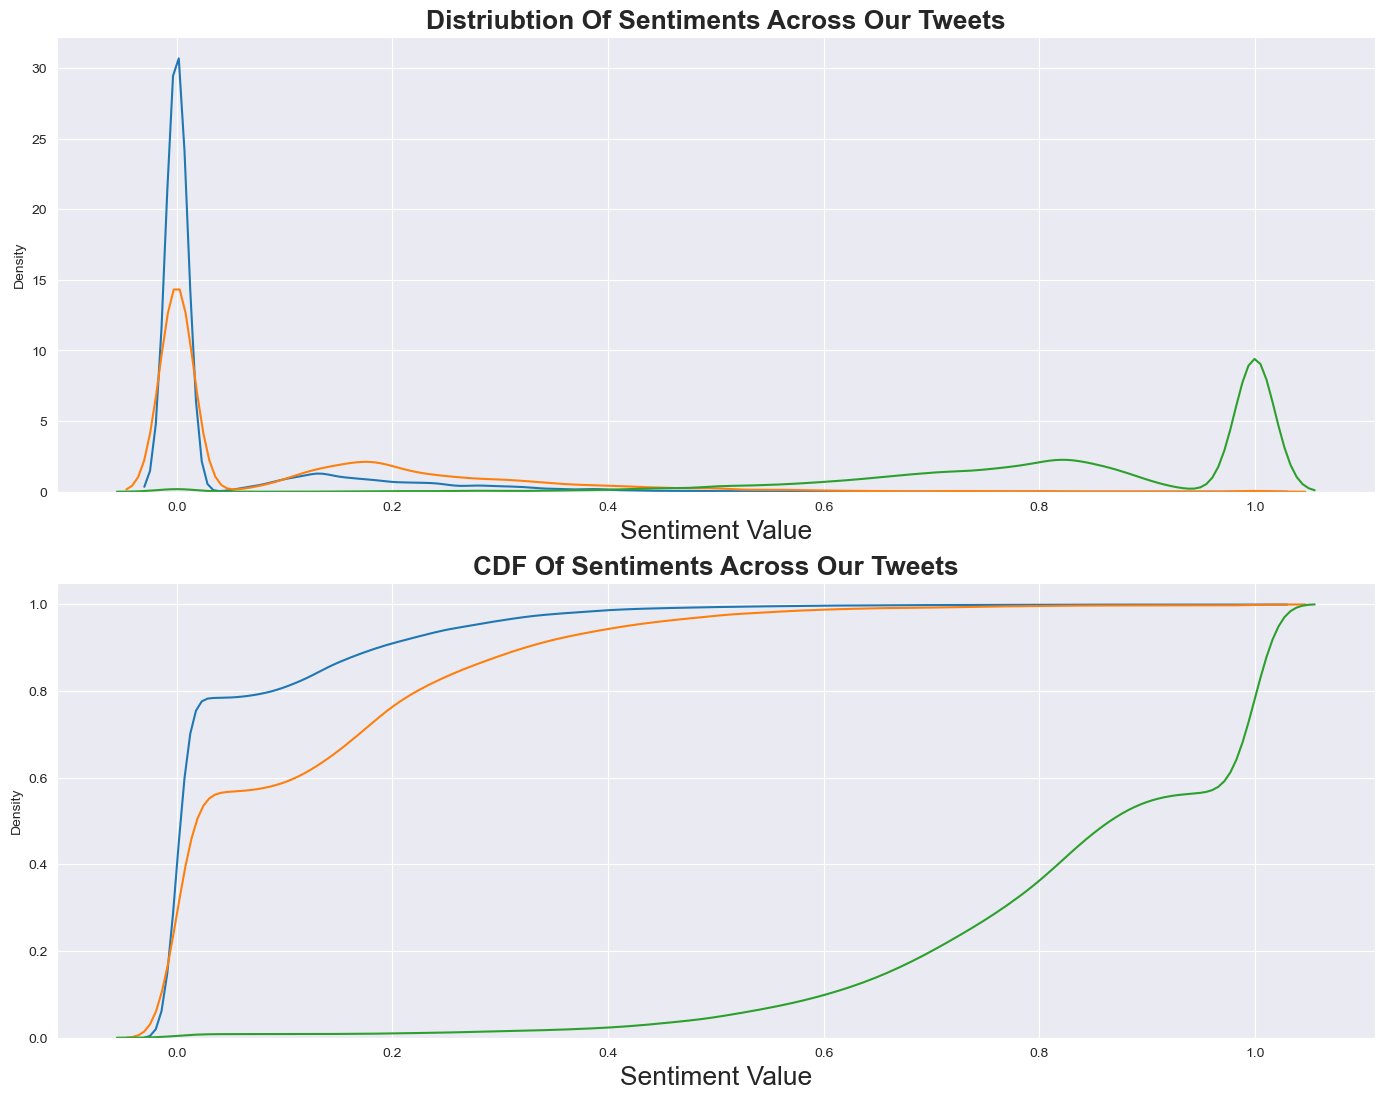

In [5]:
plt.subplot(2,1,1)
plt.title('Distriubtion Of Sentiments Across Our Tweets',fontsize=19,fontweight='bold')
sns.kdeplot(f_data['Negative Sentiment'],bw=0.1)
sns.kdeplot(f_data['Positive Sentiment'],bw=0.1)
sns.kdeplot(f_data['Neutral Sentiment'],bw=0.1)
plt.xlabel('Sentiment Value',fontsize=19)
plt.subplot(2,1,2)
plt.title('CDF Of Sentiments Across Our Tweets',fontsize=19,fontweight='bold')
sns.kdeplot(f_data['Negative Sentiment'],bw=0.1,cumulative=True)
sns.kdeplot(f_data['Positive Sentiment'],bw=0.1,cumulative=True)
sns.kdeplot(f_data['Neutral Sentiment'],bw=0.1,cumulative=True)
plt.xlabel('Sentiment Value',fontsize=19)
plt.show()

## Analyze Sentiments with Python

/var/folders/_9/rd5r68s114q89v4t4wrv38y00000gn/T/ipykernel_39169/3282500651.py:16: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.


/var/folders/_9/rd5r68s114q89v4t4wrv38y00000gn/T/ipykernel_39169/3282500651.py:32: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.




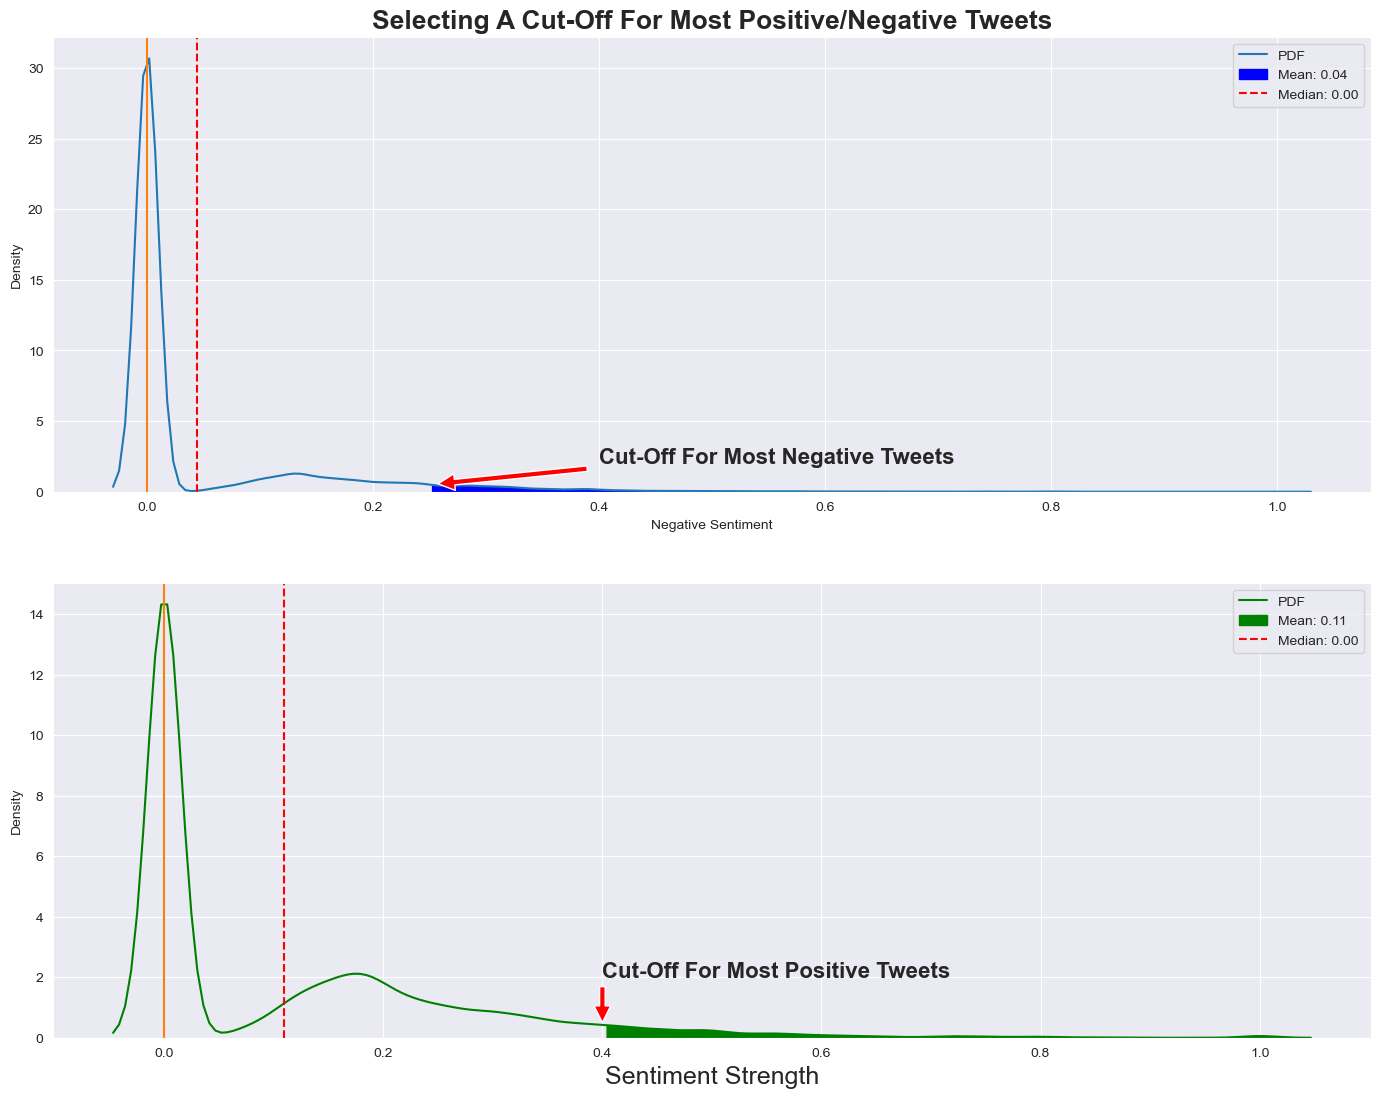

In [6]:
#Sorting And Feature Engineering
f_data = f_data.sort_values(by='date')
ft_data=f_data.copy()
ft_data['date'] = pd.to_datetime(f_data['date']).dt.date

ft_data['year']         = pd.DatetimeIndex(ft_data['date']).year
ft_data['month']        = pd.DatetimeIndex(ft_data['date']).month
ft_data['day']          = pd.DatetimeIndex(ft_data['date']).day
ft_data['day_of_year']  = pd.DatetimeIndex(ft_data['date']).dayofyear
ft_data['quarter']      = pd.DatetimeIndex(ft_data['date']).quarter
ft_data['season']       = ft_data.month%12 // 3 + 1

plt.subplot(2,1,1)
plt.title('Selecting A Cut-Off For Most Positive/Negative Tweets',fontsize=19,fontweight='bold')

ax0 = sns.kdeplot(f_data['Negative Sentiment'],bw=0.1)

kde_x, kde_y = ax0.lines[0].get_data()
ax0.fill_between(kde_x, kde_y, where=(kde_x>0.25) , 
                interpolate=True, color='b')

plt.annotate('Cut-Off For Most Negative Tweets', xy=(0.25, 0.5), xytext=(0.4, 2),
            arrowprops=dict(facecolor='red', shrink=0.05),fontsize=16,fontweight='bold')

ax0.axvline(f_data['Negative Sentiment'].mean(), color='r', linestyle='--')
ax0.axvline(f_data['Negative Sentiment'].median(), color='tab:orange', linestyle='-')
plt.legend({'PDF':f_data['Negative Sentiment'],r'Mean: {:.2f}'.format(f_data['Negative Sentiment'].mean()):f_data['Negative Sentiment'].mean(),
            r'Median: {:.2f}'.format(f_data['Negative Sentiment'].median()):f_data['Negative Sentiment'].median()})

plt.subplot(2,1,2)

ax1 = sns.kdeplot(f_data['Positive Sentiment'],bw=0.1,color='green')

plt.annotate('Cut-Off For Most Positive Tweets', xy=(0.4, 0.43), xytext=(0.4, 2),
            arrowprops=dict(facecolor='red', shrink=0.05),fontsize=16,fontweight='bold')
kde_x, kde_y = ax1.lines[0].get_data()
ax1.fill_between(kde_x, kde_y, where=(kde_x>0.4) , 
                interpolate=True, color='green')
ax1.set_xlabel('Sentiment Strength',fontsize=18)


ax1.axvline(f_data['Positive Sentiment'].mean(), color='r', linestyle='--')
ax1.axvline(f_data['Positive Sentiment'].median(), color='tab:orange', linestyle='-')
plt.legend({'PDF':f_data['Positive Sentiment'],r'Mean: {:.2f}'.format(f_data['Positive Sentiment'].mean()):f_data['Positive Sentiment'].mean(),
            r'Median: {:.2f}'.format(f_data['Positive Sentiment'].median()):f_data['Positive Sentiment'].median()})

plt.show()

## visualize the most negative and the most positive sentiments

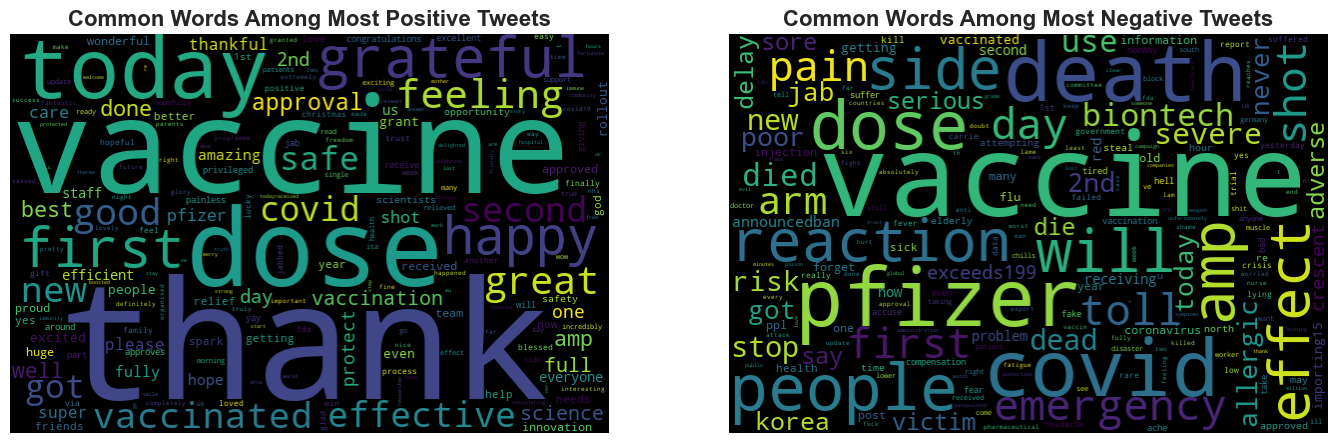

In [7]:
Most_Positive = f_data[f_data['Positive Sentiment'].between(0.4,1)]
Most_Negative = f_data[f_data['Negative Sentiment'].between(0.25,1)]

Most_Positive_text = ' '.join(Most_Positive.text)
Most_Negative_text = ' '.join(Most_Negative.text)


pwc = WordCloud(width=600,height=400,collocations = False).generate(Most_Positive_text)
nwc = WordCloud(width=600,height=400,collocations = False).generate(Most_Negative_text)

plt.subplot(1,2,1)
plt.title('Common Words Among Most Positive Tweets',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Common Words Among Most Negative Tweets',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')

plt.show()

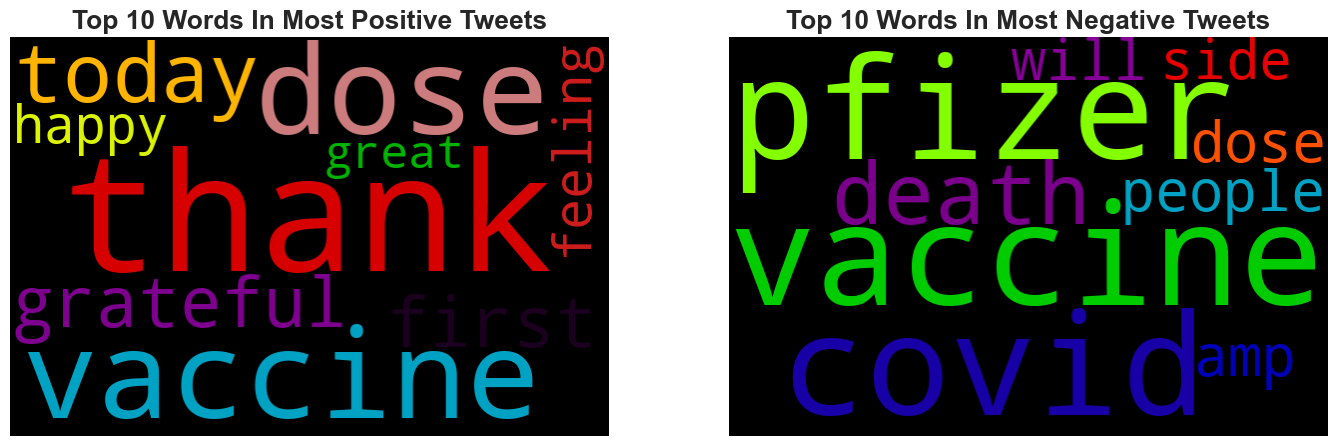

In [8]:
l_t = Most_Positive_text

w1_dict = dict()
for word in l_t.split():
    w= word.strip()
    if w in STOPWORDS:
        continue
    else:
        w1_dict[w] = w1_dict.get(w,0)+1
w1_dict = {k: v for k, v in sorted(w1_dict.items(), key=lambda item: item[1],reverse=True)}

l_t = Most_Negative_text
w2_dict = dict()
for word in l_t.split():
    w= word.strip()
    if w in STOPWORDS:
        continue
    else:
        w2_dict[w] = w2_dict.get(w,0)+1
w2_dict = {k: v for k, v in sorted(w2_dict.items(), key=lambda item: item[1],reverse=True)}

top_10_pos = list(w1_dict.keys())[:10]
top_10_neg = list(w2_dict.keys())[:10]

plt.subplot(1,2,1)
w_c = WordCloud(width=600,height=400,collocations = False,colormap='nipy_spectral').generate(' '.join(top_10_pos))
plt.title('Top 10 Words In Most Positive Tweets',fontsize=19,fontweight='bold')
plt.imshow(w_c)
plt.axis('off')
plt.subplot(1,2,2)
w_c = WordCloud(width=600,height=400,collocations = False,colormap='nipy_spectral').generate(' '.join(top_10_neg))
plt.title('Top 10 Words In Most Negative Tweets',fontsize=19,fontweight='bold')
plt.imshow(w_c)
plt.axis('off')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


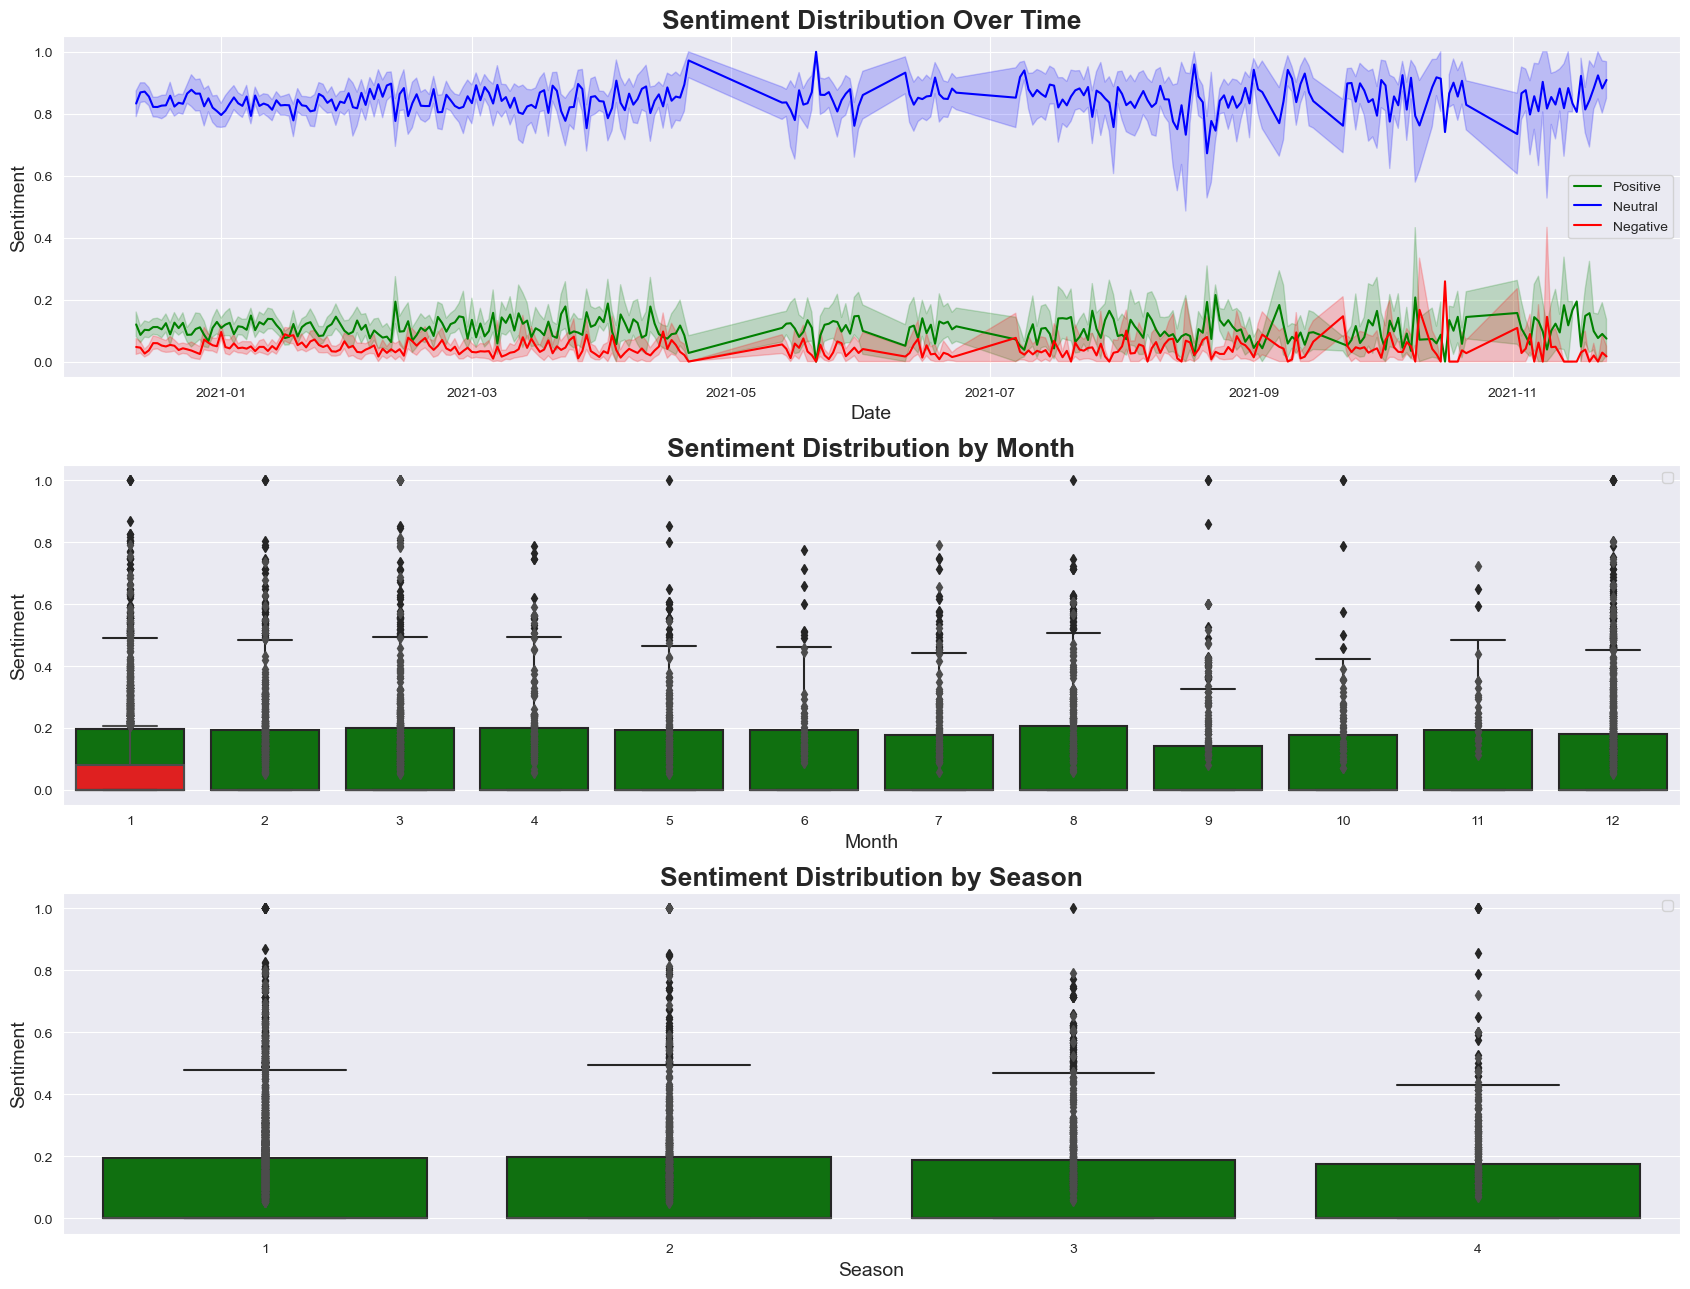

In [9]:
plt.figure(figsize=(17, 13))
plt.subplot(3, 1, 1)
plt.title('Sentiment Distribution Over Time', fontsize=19, fontweight='bold')
sns.lineplot(data=ft_data, x='date', y='Positive Sentiment', label='Positive', color='g')
sns.lineplot(data=ft_data, x='date', y='Neutral Sentiment', label='Neutral', color='b')
sns.lineplot(data=ft_data, x='date', y='Negative Sentiment', label='Negative', color='r')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sentiment', fontsize=14)
plt.legend()

plt.subplot(3, 1, 2)
plt.title('Sentiment Distribution by Month', fontsize=19, fontweight='bold')
sns.boxplot(data=ft_data, x='month', y='Positive Sentiment', color='g')
sns.boxplot(data=ft_data, x='month', y='Negative Sentiment', color='r')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Sentiment', fontsize=14)
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Sentiment Distribution by Season', fontsize=19, fontweight='bold')
sns.boxplot(data=ft_data, x='season', y='Positive Sentiment', color='g')
sns.boxplot(data=ft_data, x='season', y='Negative Sentiment', color='r')
plt.xlabel('Season', fontsize=14)
plt.ylabel('Sentiment', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()


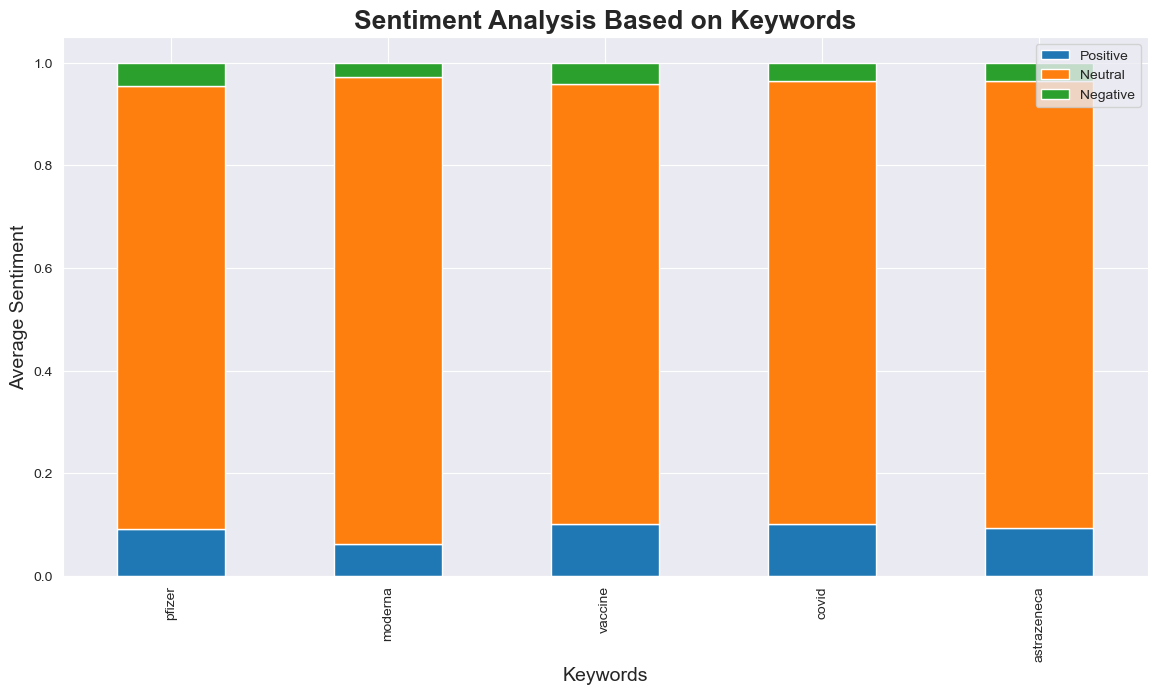

In [11]:
keywords = ['pfizer', 'moderna', 'vaccine', 'covid', 'astrazeneca']
keyword_sentiments = {}

for keyword in keywords:
    keyword_data = f_data[f_data['text'].str.contains(keyword)]
    if not keyword_data.empty:
        keyword_sentiments[keyword] = {
            'Positive': keyword_data['Positive Sentiment'].mean(),
            'Neutral': keyword_data['Neutral Sentiment'].mean(),
            'Negative': keyword_data['Negative Sentiment'].mean()
        }

keyword_sentiments_df = pd.DataFrame(keyword_sentiments).T

keyword_sentiments_df.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Sentiment Analysis Based on Keywords', fontsize=19, fontweight='bold')
plt.xlabel('Keywords', fontsize=14)
plt.ylabel('Average Sentiment', fontsize=14)
plt.legend(loc='upper right')
plt.show()


In [14]:
import plotly.express as px

fig = px.line(ft_data, x='date', y=['Positive Sentiment', 'Neutral Sentiment', 'Negative Sentiment'],
              labels={'date': 'Date', 'value': 'Sentiment Value'}, title='Sentiment Distribution Over Time')

fig.update_layout(yaxis_title='Sentiment Value', xaxis_title='Date')
fig.show()


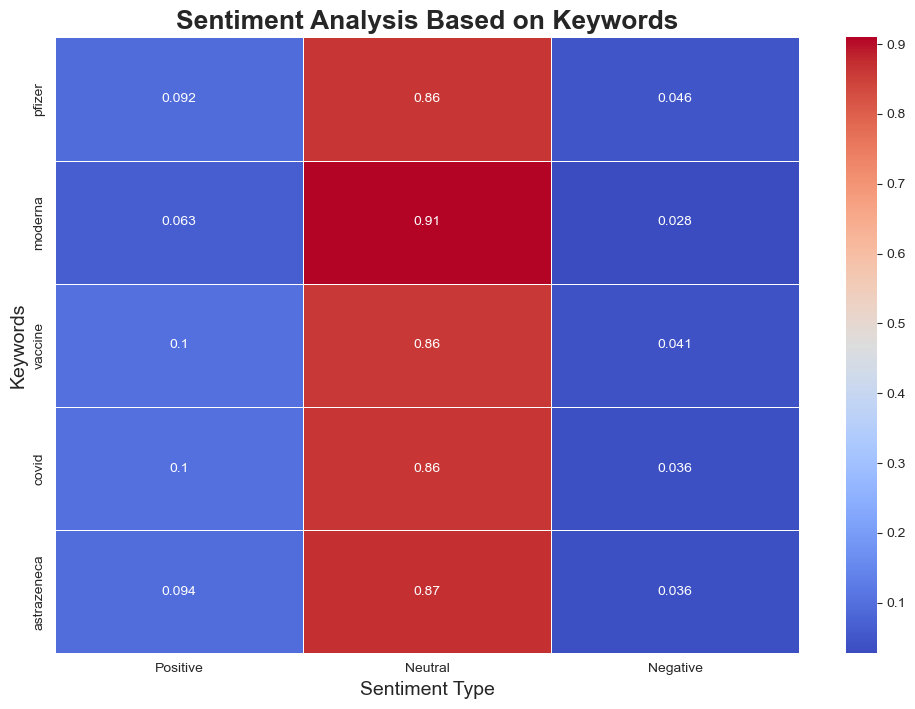

In [15]:
keywords = ['pfizer', 'moderna', 'vaccine', 'covid', 'astrazeneca']
keyword_sentiments = {}

for keyword in keywords:
    keyword_data = f_data[f_data['text'].str.contains(keyword)]
    if not keyword_data.empty:
        keyword_sentiments[keyword] = {
            'Positive': keyword_data['Positive Sentiment'].mean(),
            'Neutral': keyword_data['Neutral Sentiment'].mean(),
            'Negative': keyword_data['Negative Sentiment'].mean()
        }

keyword_sentiments_df = pd.DataFrame(keyword_sentiments).T

plt.figure(figsize=(12, 8))
sns.heatmap(keyword_sentiments_df, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Sentiment Analysis Based on Keywords', fontsize=19, fontweight='bold')
plt.xlabel('Sentiment Type', fontsize=14)
plt.ylabel('Keywords', fontsize=14)
plt.show()


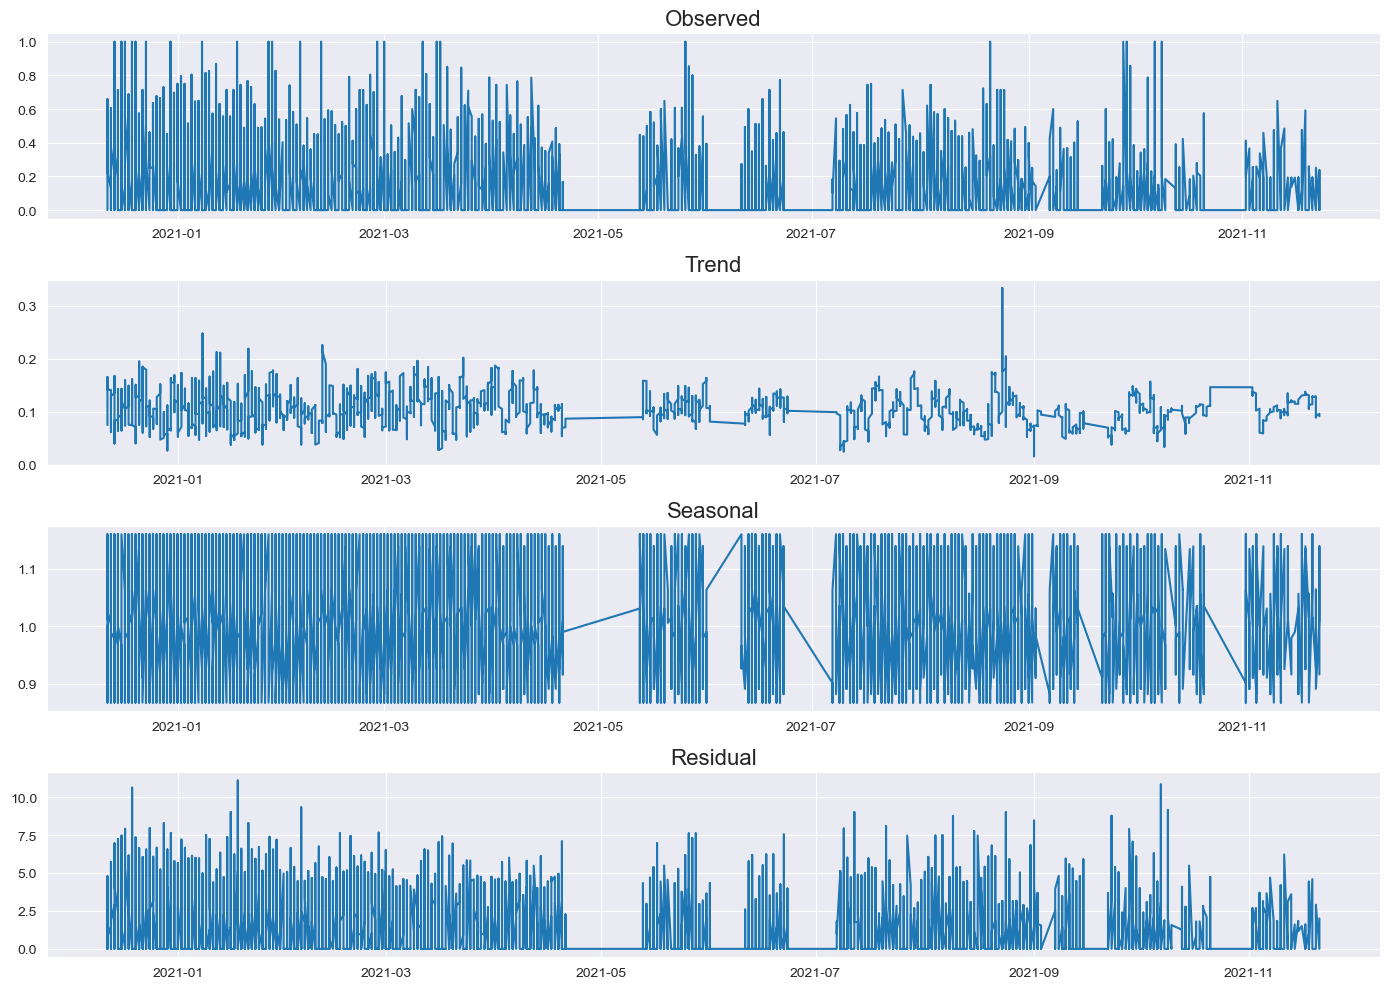

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

ft_data.set_index('date', inplace=True)
result = seasonal_decompose(ft_data['Positive Sentiment'], model='multiplicative', period=30)

plt.figure(figsize=(14, 10))
plt.subplot(4, 1, 1)
plt.plot(result.observed)
plt.title('Observed', fontsize=16)
plt.subplot(4, 1, 2)
plt.plot(result.trend)
plt.title('Trend', fontsize=16)
plt.subplot(4, 1, 3)
plt.plot(result.seasonal)
plt.title('Seasonal', fontsize=16)
plt.subplot(4, 1, 4)
plt.plot(result.resid)
plt.title('Residual', fontsize=16)
plt.tight_layout()
plt.show()
